---
title: AERO 417 Project 1
---

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

takeoff_thrust = 12000
pressure_ambient = 1.01
temperature_ambient = 288

P_compressor = 4.15
m_dot = 20
turbine_inlet_temperature = 1100

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.9
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

In [2]:
# Design Variables
N = 250
U_tip = 355.3
C_axial = 150
outlet_radius_mean = 0.1697

In [3]:
T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = U_tip/N/2/np.pi
rr_rt = (1-m_dot/(np.pi*rho1*C1)/inlet_radius_tip**2)**0.5
inlet_radius_root = rr_rt*inlet_radius_tip

print("Inlet")
print("Tip:",inlet_radius_tip)
print("Root:",inlet_radius_root)

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2
h = A2/2/np.pi/outlet_radius_mean

outlet_radius_tip = outlet_radius_mean+h/2
outlet_radius_root = outlet_radius_mean-h/2

print("Outlet")
print("Tip:",outlet_radius_tip)
print("Root:",outlet_radius_root)

Inlet
Tip: 0.22619100512220167
Root: 0.11318429525851725
Outlet
Tip: 0.190323194216562
Root: 0.149076805783438


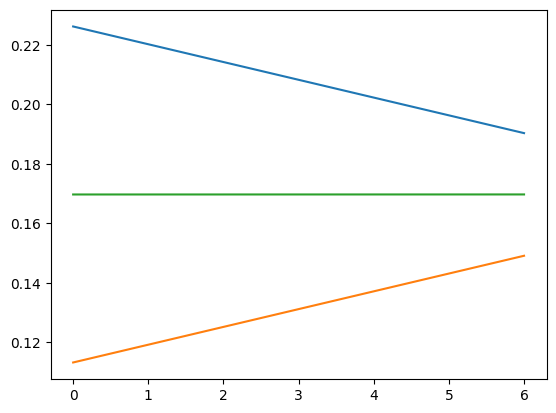

In [9]:
import matplotlib.pyplot as plt
tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
mean_radius = [(t+r)/2 for t,r in zip(tips,roots)]
plt.plot(tips)
plt.plot(roots)
plt.plot(mean_radius)

In [4]:
U_mean = 2*np.pi*N*outlet_radius_mean
Beta1 = np.arctan(U_mean/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

ideal_temperature_rise = U_mean*C_axial*(np.tan(Beta1)-np.tan(Beta2))/Cp
num_stages = int(np.ceil((T2-T1)/ideal_temperature_rise)+1)

print("Stages:",num_stages)

mean_temperature_rise = (T2-T1)/num_stages

min_temperature_rise = mean_temperature_rise-mean_temperature_rise%(np.ceil(mean_temperature_rise/5))
max_temperature_rise = ((T2-T1)-2*min_temperature_rise)/(num_stages-2)
temperature_rise = []
temperature_rise.append(min_temperature_rise)
temperature_rise.extend((num_stages-2)*[max_temperature_rise])
temperature_rise.append(min_temperature_rise)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

C1_swirl = [0]

swirl_change = Cp*temperature_rise[0]/work_done[0]/U_mean
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

V2_V1 = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean,0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/U_mean/C_axial-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    V2_V1.append(np.cos(Alpha2)/np.cos(Alpha1))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])

Stages: 7


In [5]:
df = {"Inlet_T0":Inlet_T0,"Outlet_T0":Outlet_T0,"Inlet_P0":Inlet_P0,"Outlet_P0":Outlet_P0,"P_ratio":P_ratio,"Inlet_swirl":C1_swirl,"Outlet_swirl":C2_swirl}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl
1,288.000000,308.000000,1.010000,1.248742,1.236378,0.000000,76.942849
2,308.000000,332.895759,1.248742,1.596665,1.278619,29.505810,130.432672
3,332.895759,357.791519,1.596665,2.005517,1.256066,79.951397,186.612740
4,357.791519,382.687278,2.005517,2.480587,1.236881,76.738706,189.825431
5,382.687278,407.583037,2.480587,3.027218,1.220364,76.738706,189.825431
6,407.583037,432.478797,3.027218,3.650806,1.205994,76.738706,189.825431
7,432.478797,452.478797,3.650806,4.210873,1.153409,87.857977,178.706160


In [86]:
T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = 0.22619

rr_rt = (1-m_dot/(np.pi*rho1*C1)/inlet_radius_tip**2)**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_root+inlet_radius_tip)/2

print("Inlet")
print("Tip:",inlet_radius_tip)
print("Root:",inlet_radius_root)

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_tip = inlet_radius_tip
outlet_radius_root = np.sqrt(outlet_radius_tip**2-A2/np.pi)

print("Outlet")
print("Tip:",outlet_radius_tip)
print("Root:",outlet_radius_root)

Inlet
Tip: 0.22619
Root: 0.11318228657778283
Outlet
Tip: 0.22619
Root: 0.1927767928610644


In [101]:
num_stages = 5
tips = num_stages*[outlet_radius_tip]
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]
U_mean = [2*np.pi*N*m for m in means]

Beta1 = np.arctan(U_mean[0]/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

temperature_rise = [(T02-T01)/5 for _ in range(num_stages)]

C1_swirl = [0]
swirl_change = (Cp*temperature_rise[0]/work_done[0]+U_mean[0]*C1_swirl[-1])/U_mean[1]
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean[0]/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean[0]-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean[0],0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/C_axial/U_mean[idx]-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean[idx]-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])

In [102]:
df = {"Inlet_T0":Inlet_T0,"Outlet_T0":Outlet_T0,"Inlet_P0":Inlet_P0,"Outlet_P0":Outlet_P0,"P_ratio":P_ratio,"Inlet_swirl":C1_swirl,"Outlet_swirl":C2_swirl,"De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl,De_Haller
1,288.000000,320.895759,1.010000,1.422522,1.408438,0.000000,119.555060,0.686650
2,320.895759,353.791519,1.422522,1.937321,1.361892,21.659839,147.642590,0.670269
3,353.791519,386.687278,1.937321,2.566604,1.324821,85.822682,211.976379,0.665496
4,386.687278,419.583037,2.566604,3.322751,1.294610,93.171696,220.255709,0.662639
5,419.583037,452.478797,3.322751,4.218303,1.269521,104.003766,225.051984,0.674884
